In [1]:
%pip install ydata-profiling
%pip install ipywidgets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.1 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=f0e956cea381a4078910545184e205b771e86b8ec5b10caba37aad863b87a817
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


# Análisis Exploratorio

In [2]:
import pandas as pd
from ydata_profiling import ProfileReport

# Cargar el archivo CSV
df_train = pd.read_csv('train.csv')

# Generar el reporte de análisis exploratorio y mostrarlo en el notebook
profile = ProfileReport(df_train, title="Exploratory Data Analysis Report", explorative=True)

# Mostrar el reporte dentro del Jupyter Notebook
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Limpieza de datos

In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk

nltk.download('punkt')
nltk.download('stopwords')


def limpiar_texto(texto):
    if texto is None:
        return ""
    texto = texto.lower()
    texto = re.sub(r"[#@']", "", texto)
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto, flags=re.MULTILINE)
    texto = texto.encode('ascii', 'ignore').decode('ascii')
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(texto)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    texto_limpio = ' '.join(tokens)
    return texto_limpio



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import json
def latex_a_texto(latex):
    texto = re.sub(r'\\begin\{itemize\}', '', latex)
    texto = re.sub(r'\\end\{itemize\}', '', texto)
    texto = re.sub(r'\\item\s*', '\n', texto)
    texto = re.sub(r'\\[a-zA-Z]+\{[^}]*\}', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

def convertir_a_lista(texto):
    try:
        return json.loads(texto)
    except json.JSONDecodeError:
        return texto

In [5]:
import ast
df_train['prompt'] = df_train['prompt'].apply(ast.literal_eval)

In [6]:
df_train['prompt_limpio'] = df_train['prompt'].apply(lambda lista: [limpiar_texto(texto) for texto in lista])

In [7]:
df_train['response_a_texto'] = df_train['response_a'].apply(latex_a_texto)
df_train['response_b_texto'] = df_train['response_b'].apply(latex_a_texto)

In [8]:
df_train['response_a_texto'] = df_train['response_a_texto'].apply(convertir_a_lista)
df_train['response_b_texto'] = df_train['response_b_texto'].apply(convertir_a_lista)

Probando leer una conversación entre el usuario y el modelo:

In [9]:
for i in range(len(df_train["prompt"][0])):
  print(i)
  print(df_train["prompt"][0][i])
  print("\n")
  print(df_train["response_a_texto"][0][i])
  print("\n")
  print(df_train["response_b_texto"][0][i])
  print("\n")

0
Is it morally right to try to have a certain percentage of females on managerial positions?


The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.

Here are some arguments in favor of and against such policies:

**Arguments in favor:**

1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.

2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizations and society as a whole.

3. **Equality of Opportunity:** Setting targets for female representation in management can help ensure tha

Terminando de limpiar:

In [10]:
df_train['response_a_limpio']=df_train['response_a_texto'].apply(lambda lista: [limpiar_texto(texto) for texto in lista])

In [11]:
df_train['response_b_limpio']=df_train['response_b_texto'].apply(lambda lista: [limpiar_texto(texto) for texto in lista])

Cruce de variables importantes y graficos exploratorios

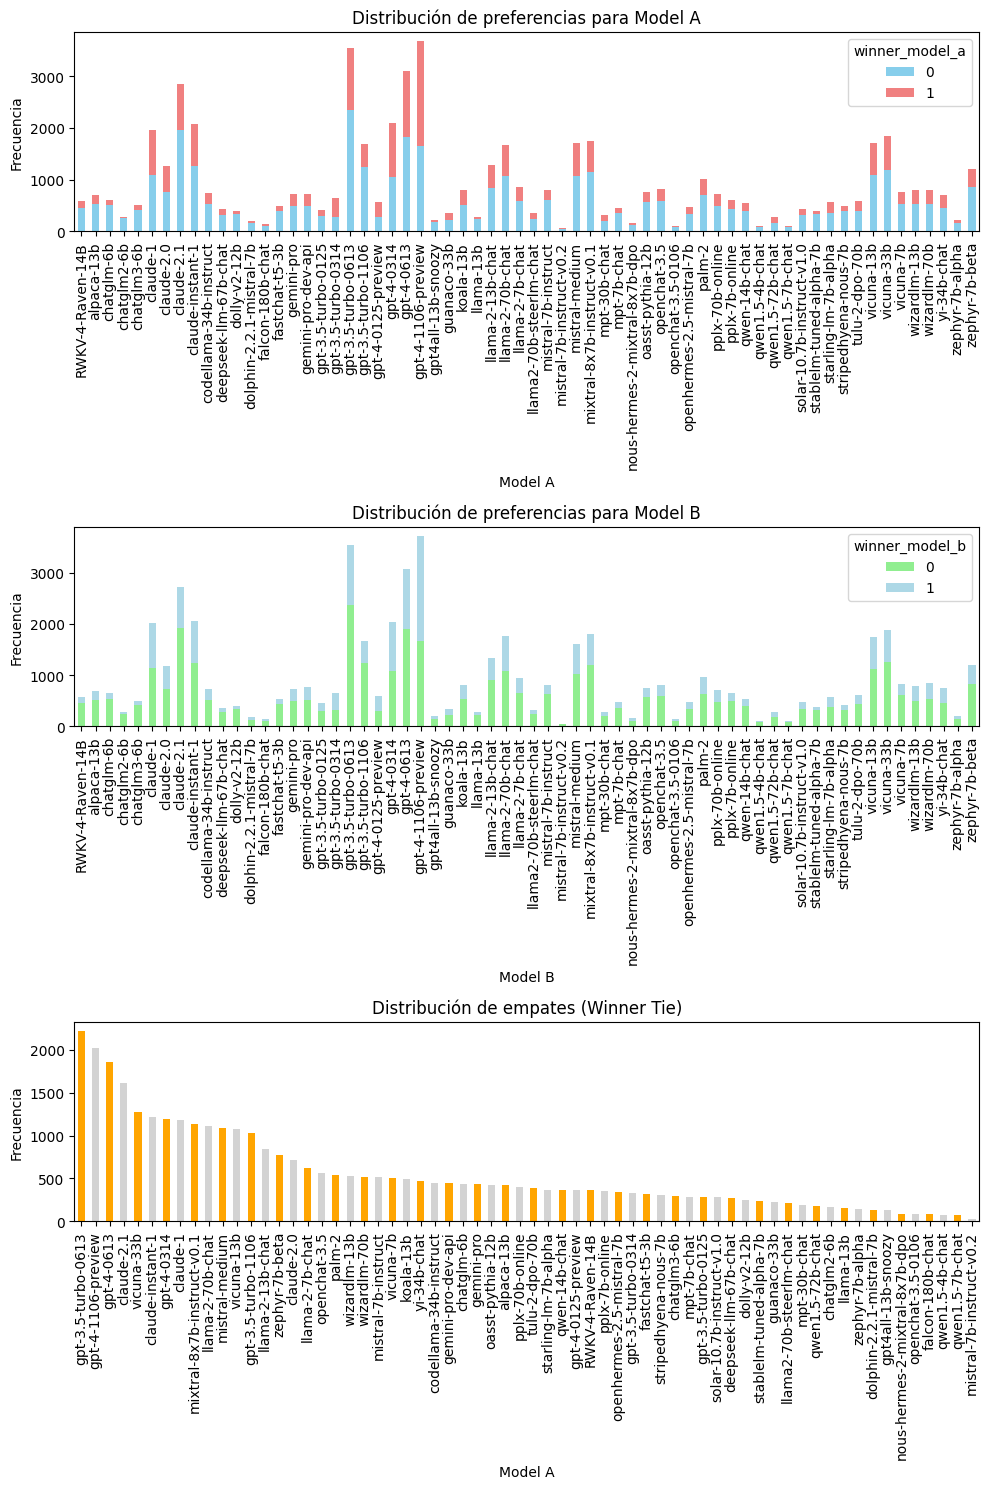

In [25]:
import matplotlib.pyplot as plt

# Cruce de preferencias con los modelos
cross_a = pd.crosstab(df_train['model_a'], df_train['winner_model_a'])
cross_b = pd.crosstab(df_train['model_b'], df_train['winner_model_b'])
# Concatenar los modelos A y B para evitar duplicados en los empates
all_models_tie = pd.concat([df_train[['model_a', 'winner_tie']],
                            df_train[['model_b', 'winner_tie']].rename(columns={'model_b': 'model_a'})])

# Contar los empates por modelo
tie_counts = all_models_tie[all_models_tie['winner_tie'] == 1]['model_a'].value_counts()

# Gráfico de barras para visualización
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Gráfico para el modelo A
cross_a.plot(kind='bar', stacked=True, ax=axs[0], color=['skyblue', 'lightcoral'])
axs[0].set_title('Distribución de preferencias para Model A')
axs[0].set_xlabel('Model A')
axs[0].set_ylabel('Frecuencia')

# Gráfico para el modelo B
cross_b.plot(kind='bar', stacked=True, ax=axs[1], color=['lightgreen', 'lightblue'])
axs[1].set_title('Distribución de preferencias para Model B')
axs[1].set_xlabel('Model B')
axs[1].set_ylabel('Frecuencia')

# Gráfico para los empates
tie_counts.plot(kind='bar', stacked=True, ax=axs[2], color=['orange', 'lightgrey'])
axs[2].set_title('Distribución de empates (Winner Tie)')
axs[2].set_xlabel('Model A')
axs[2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


In [27]:
#Modelos que más veces ganaron en Model A
top_winner_model_a = cross_a.sum(axis=1).sort_values(ascending=False).head()

# Modelos que más veces ganaron en Model B
top_winner_model_b = cross_b.sum(axis=1).sort_values(ascending=False).head()

top_winner_model_a, top_winner_model_b, tie_counts

(model_a
 gpt-4-1106-preview    3678
 gpt-3.5-turbo-0613    3553
 gpt-4-0613            3099
 claude-2.1            2859
 gpt-4-0314            2087
 dtype: int64,
 model_b
 gpt-4-1106-preview    3709
 gpt-3.5-turbo-0613    3530
 gpt-4-0613            3066
 claude-2.1            2724
 claude-instant-1      2051
 dtype: int64,
 model_a
 gpt-3.5-turbo-0613          2217
 gpt-4-1106-preview          2027
 gpt-4-0613                  1859
 claude-2.1                  1614
 vicuna-33b                  1274
                             ... 
 openchat-3.5-0106             85
 falcon-180b-chat              83
 qwen1.5-4b-chat               76
 qwen1.5-7b-chat               68
 mistral-7b-instruct-v0.2      28
 Name: count, Length: 64, dtype: int64)

Los resultados muestran que el modelo gpt-4-1106-preview es consistentemente uno de los más preferidos por los usuarios, con 3678 preferencias en el rol de Model A y 3709 en Model B. Este modelo destaca significativamente en las interacciones, lo que sugiere que sus respuestas son frecuentemente valoradas como las mejores. Le sigue el modelo gpt-3.5-turbo-0613, con un rendimiento igualmente fuerte en ambas posiciones: 3553 preferencias en Model A y 3530 en Model B, lo que lo convierte en un competidor muy robusto.

En cuanto a los empates, gpt-3.5-turbo-0613 lidera con 2217 empates, seguido de cerca por gpt-4-1106-preview con 2027, lo que indica que los usuarios encuentran difícil elegir entre las respuestas de estos dos modelos en muchas ocasiones. Otros modelos relevantes incluyen gpt-4-0613 y claude-2.1, que también reciben una cantidad considerable de preferencias en las tres categorías (Model A, Model B y empates), aunque en menor medida. Por otro lado, modelos como gpt-4-0314 y claude-instant-1 presentan una participación más modesta.

Estos datos sugieren que los modelos GPT, en sus diversas versiones, tienden a dominar en términos de preferencias del usuario, con frecuentes empates entre ellos, lo que resalta la alta calidad y competitividad de sus respuestas.

In [23]:
# Contar cuántas respuestas en total hay de cada modelo en Model A y Model B
model_a_counts = df_train['model_a'].value_counts()
model_b_counts = df_train['model_b'].value_counts()

# Sumar las respuestas de los modelos que aparecen en ambas columnas
total_model_responses = model_a_counts.add(model_b_counts, fill_value=0)

# Ahora sumar las veces que cada modelo aparece en un empate (combinando Model A y Model B)
# Concatenar los modelos para los empates
all_models_tie = pd.concat([df_train[['model_a', 'winner_tie']],
                            df_train[['model_b', 'winner_tie']].rename(columns={'model_b': 'model_a'})])

# Contar los empates por modelo
tie_counts = all_models_tie[all_models_tie['winner_tie'] == 1]['model_a'].value_counts()

# Sumar las veces que cada modelo participó en un empate al conteo total de respuestas
total_model_responses_with_ties = total_model_responses.add(tie_counts, fill_value=0).sort_values(ascending=False)

# Mostrar el total de respuestas por modelo, incluyendo empates
total_model_responses_with_ties.head()


,count
gpt-4-1106-preview,9414
gpt-3.5-turbo-0613,9300
gpt-4-0613,8024
claude-2.1,7197
claude-instant-1,5350
